In [1]:
import pandas as pd
import numpy as np
import time as t
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

# Gather Data from Local File

In [2]:
games = pd.read_csv('nfl-big-data-bowl-2021/games.csv')
games

gameId    gameDate gameTimeEastern homeTeamAbbr visitorTeamAbbr  week
0    2018090600  09/06/2018        20:20:00          PHI             ATL     1
1    2018090901  09/09/2018        13:00:00          CLE             PIT     1
2    2018090902  09/09/2018        13:00:00          IND             CIN     1
3    2018090903  09/09/2018        13:00:00          MIA             TEN     1
4    2018090900  09/09/2018        13:00:00          BAL             BUF     1
..          ...         ...             ...          ...             ...   ...
248  2018123013  12/30/2018        16:25:00          DEN             LAC    17
249  2018123015  12/30/2018        16:25:00          SEA             ARI    17
250  2018123014  12/30/2018        16:25:00           LA              SF    17
251  2018122200  12/22/2018        16:30:00          TEN             WAS    16
252  2018122201  12/22/2018        20:20:00          LAC             BAL    16

[253 rows x 6 columns]

In [3]:
players = pd.read_csv('nfl-big-data-bowl-2021/players.csv')
players

nflId height  weight   birthDate             collegeName position  \
0     2539334     72     190  1990-09-10              Washington       CB   
1     2539653     70     186  1988-11-01  Southeastern Louisiana       CB   
2     2543850     69     186  1991-12-18                  Purdue       SS   
3     2555162     73     227  1994-11-04         Louisiana State      MLB   
4     2555255     75     232  1993-07-01               Minnesota      OLB   
...       ...    ...     ...         ...                     ...      ...   
1298  2553798    6-2     235  09/17/1991              Vanderbilt       LS   
1299  2556814    6-2     200  05/17/1994                    Duke       WR   
1300  2552576     78     231  1992-04-25            Oregon State       QB   
1301  2561469     69     187  1993-03-15      Alabama-Birmingham       CB   
1302  2558095    6-2     196  10/12/1995                     LSU       WR   

             displayName  
0        Desmond Trufant  
1          Robert Alford  
2          Ricardo Allen  
3            Deion Jones  
4     De'Vondre Campbell  
...                  ...  
1298         Andrew East  
1299       Max McCaffrey  
1300        Sean Mannion  
1301    Darious Williams  
1302       Malachi Dupre  

[1303 rows x 7 columns]

In [4]:
## Adjust Player Hight to decimal feet
height = []
for row in players['height'].str.split('-'):
    if len(row) != 1:
        height.append((int(row[0])*12 + int(row[1]))/12)
    else:
        height.append(int(row[0])/12)

In [5]:
players['height'] = height

In [7]:
## Calculate Player Age
#Regular season end: 12/30/2018
age = []
for row in players['birthDate'].str.split('-'):
    if '/' in row[0]:
        format_row = row[0].split('/')
        age.append(2019 - int(format_row[2]) - ((int(format_row[0])-1)*30 + int(format_row[1]))/360)
    else:
        age.append(2019 - int(row[0]) - ((int(row[1])-1)*30 + int(row[2]))/360)

In [8]:
players['age'] = age

In [9]:
players.head()

nflId    height  weight   birthDate             collegeName position  \
0  2539334  6.000000     190  1990-09-10              Washington       CB   
1  2539653  5.833333     186  1988-11-01  Southeastern Louisiana       CB   
2  2543850  5.750000     186  1991-12-18                  Purdue       SS   
3  2555162  6.083333     227  1994-11-04         Louisiana State      MLB   
4  2555255  6.250000     232  1993-07-01               Minnesota      OLB   

          displayName        age  
0     Desmond Trufant  28.305556  
1       Robert Alford  30.163889  
2       Ricardo Allen  27.033333  
3         Deion Jones  24.155556  
4  De'Vondre Campbell  25.497222

In [10]:
plays = pd.read_csv('nfl-big-data-bowl-2021/plays.csv')
plays

gameId  playId                                    playDescription  \
0      2018090600      75  (15:00) M.Ryan pass short right to J.Jones pus...   
1      2018090600     146  (13:10) M.Ryan pass incomplete short right to ...   
2      2018090600     168  (13:05) (Shotgun) M.Ryan pass incomplete short...   
3      2018090600     190  (13:01) (Shotgun) M.Ryan pass deep left to J.J...   
4      2018090600     256  (10:59) (Shotgun) M.Ryan pass incomplete short...   
...           ...     ...                                                ...   
19234  2018122200    2300  (7:53) J.Johnson pass incomplete short left [K...   
19235  2018122200    3177  (6:53) (Shotgun) B.Gabbert pass incomplete sho...   
19236  2018122201     566  (5:32) (Shotgun) P.Rivers pass deep right to K...   
19237  2018122201    1719  (1:08) P.Rivers pass incomplete deep middle to...   
19238  2018122201    2649  (7:16) (Shotgun) L.Jackson pass incomplete sho...   

       quarter  down  yardsToGo possessionTeam           playType  \
0            1     1         15            ATL     play_type_pass   
1            1     1         10            ATL     play_type_pass   
2            1     2         10            ATL     play_type_pass   
3            1     3         10            ATL     play_type_pass   
4            1     3          1            ATL     play_type_pass   
...        ...   ...        ...            ...                ...   
19234        3     2          5            WAS  play_type_unknown   
19235        4     3          7            TEN  play_type_unknown   
19236        1     3          4            LAC  play_type_unknown   
19237        2     3          1            LAC  play_type_unknown   
19238        3     1         10            BAL  play_type_unknown   

      yardlineSide  yardlineNumber  ... preSnapHomeScore gameClock  \
0              ATL              20  ...              0.0  15:00:00   
1              PHI              39  ...              0.0  13:10:00   
2              PHI              39  ...              0.0  13:05:00   
3              PHI              39  ...              0.0  13:01:00   
4              PHI               1  ...              0.0  10:59:00   
...            ...             ...  ...              ...       ...   
19234          WAS              31  ...              NaN       NaN   
19235          WAS              37  ...              NaN       NaN   
19236          LAC              49  ...              NaN       NaN   
19237          LAC              48  ...              NaN       NaN   
19238          LAC              49  ...              NaN       NaN   

       absoluteYardlineNumber  penaltyCodes penaltyJerseyNumbers passResult  \
0                        90.0           NaN                  NaN          C   
1                        49.0           NaN                  NaN          I   
2                        49.0           NaN                  NaN          I   
3                        49.0           NaN                  NaN          C   
4                        11.0           NaN                  NaN          I   
...                       ...           ...                  ...        ...   
19234                     NaN            DH               TEN 24          I   
19235                     NaN            DH               WAS 31          I   
19236                     NaN           OPI               LAC 13          C   
19237                     NaN           DPI               BAL 23          I   
19238                     NaN           DPI               LAC 43          I   

       offensePlayResult  playResult       epa  isDefensivePI  
0                     10          10  0.261827          False  
1                      0           0 -0.372360          False  
2                      0           0 -0.702779          False  
3                     33          33  3.047530          False  
4                      0           0 -0.842272          False  
...                  ...         ...       ... 

In [11]:
## Drop unnecessary columns
plays = plays.drop(['playDescription','playType','yardlineSide','yardlineNumber','typeDropback','penaltyCodes', 'penaltyJerseyNumbers'], axis = 1)

In [12]:
## Calculate time left in the game
time = []
game_clock = plays['gameClock'].str.split(':')
quarter = plays['quarter']
for row in range(0,len(game_clock)):
    if game_clock[row] != game_clock[row]:
        time.append(float("nan"))
    else:
        time.append(60 - (quarter[row] - 1)*15  - (15 - (int(game_clock[row][0]) + int(game_clock[row][1])/60)))

In [13]:
plays['timeRemaining'] = time
plays = plays.drop(['quarter','gameClock'], axis = 1)
plays.head()

gameId  playId  down  yardsToGo possessionTeam offenseFormation  \
0  2018090600      75     1         15            ATL           I_FORM   
1  2018090600     146     1         10            ATL       SINGLEBACK   
2  2018090600     168     2         10            ATL          SHOTGUN   
3  2018090600     190     3         10            ATL          SHOTGUN   
4  2018090600     256     3          1            ATL          SHOTGUN   

         personnelO  defendersInTheBox  numberOfPassRushers        personnelD  \
0  2 RB, 1 TE, 2 WR                7.0                  4.0  4 DL, 2 LB, 5 DB   
1  1 RB, 1 TE, 3 WR                7.0                  4.0  4 DL, 2 LB, 5 DB   
2  2 RB, 1 TE, 2 WR                6.0                  4.0  4 DL, 2 LB, 5 DB   
3  1 RB, 1 TE, 3 WR                6.0                  5.0  4 DL, 1 LB, 6 DB   
4  2 RB, 3 TE, 0 WR                8.0                  6.0  6 DL, 3 LB, 2 DB   

   preSnapVisitorScore  preSnapHomeScore  absoluteYardlineNumber passResult  \
0                  0.0               0.0                    90.0          C   
1                  0.0               0.0                    49.0          I   
2                  0.0               0.0                    49.0          I   
3                  0.0               0.0                    49.0          C   
4                  0.0               0.0                    11.0          I   

   offensePlayResult  playResult       epa  isDefensivePI  timeRemaining  
0                 10          10  0.261827          False      60.000000  
1                  0           0 -0.372360          False      58.166667  
2                  0           0 -0.702779          False      58.083333  
3                 33          33  3.047530          False      58.016667  
4                  0           0 -0.842272          False      55.983333

In [14]:
plays.head()

gameId  playId  down  yardsToGo possessionTeam offenseFormation  \
0  2018090600      75     1         15            ATL           I_FORM   
1  2018090600     146     1         10            ATL       SINGLEBACK   
2  2018090600     168     2         10            ATL          SHOTGUN   
3  2018090600     190     3         10            ATL          SHOTGUN   
4  2018090600     256     3          1            ATL          SHOTGUN   

         personnelO  defendersInTheBox  numberOfPassRushers        personnelD  \
0  2 RB, 1 TE, 2 WR                7.0                  4.0  4 DL, 2 LB, 5 DB   
1  1 RB, 1 TE, 3 WR                7.0                  4.0  4 DL, 2 LB, 5 DB   
2  2 RB, 1 TE, 2 WR                6.0                  4.0  4 DL, 2 LB, 5 DB   
3  1 RB, 1 TE, 3 WR                6.0                  5.0  4 DL, 1 LB, 6 DB   
4  2 RB, 3 TE, 0 WR                8.0                  6.0  6 DL, 3 LB, 2 DB   

   preSnapVisitorScore  preSnapHomeScore  absoluteYardlineNumber passResult  \
0                  0.0               0.0                    90.0          C   
1                  0.0               0.0                    49.0          I   
2                  0.0               0.0                    49.0          I   
3                  0.0               0.0                    49.0          C   
4                  0.0               0.0                    11.0          I   

   offensePlayResult  playResult       epa  isDefensivePI  timeRemaining  
0                 10          10  0.261827          False      60.000000  
1                  0           0 -0.372360          False      58.166667  
2                  0           0 -0.702779          False      58.083333  
3                 33          33  3.047530          False      58.016667  
4                  0           0 -0.842272          False      55.983333

In [15]:
## EDA Figure out defending team preferences
plays_defending = plays.join(games.set_index('gameId'), on = 'gameId', rsuffix = '_games')

plays_defending['defendingTeam'] = np.where(plays_defending['homeTeamAbbr'] == plays_defending['possessionTeam'], plays_defending['visitorTeamAbbr'],plays_defending['homeTeamAbbr'])

In [16]:
plays_defending[['defendingTeam','defendersInTheBox', 'numberOfPassRushers']].groupby('defendingTeam').mean().sort_values(by = 'defendersInTheBox', ascending = False)

defendersInTheBox  numberOfPassRushers
defendingTeam                                        
ARI                     6.433333             4.422868
CAR                     6.307958             4.369449
MIN                     6.267717             4.172764
MIA                     6.206093             4.262082
NO                      6.199067             4.317590
CLE                     6.197059             4.338906
NYJ                     6.193038             4.302782
TEN                     6.181034             4.166960
WAS                     6.171381             4.199313
BUF                     6.153846             4.257143
NYG                     6.152066             4.166667
DEN                     6.140598             4.296364
LA                      6.127334             4.259649
SF                      6.087971             4.180970
OAK                     6.086614             4.116090
NE                      6.060372             4.295419
JAX                     6.034483             4.196262
PHI                     6.030837             4.256716
GB                      6.028961             4.170475
DAL                     6.013445             4.205172
SEA                     6.010676             4.138686
TB                      5.981229             4.246935
HOU                     5.972179             4.094340
ATL                     5.971787             4.199352
BAL                     5.939158             4.332795
CIN                     5.938583             4.135922
KC                      5.932024             4.218354
IND                     5.748311             4.041451
CHI                     5.729290             4.074018
LAC                     5.711033             4.023423
PIT                     5.676236             4.417349
DET                     5.571942             4.003711

In [17]:
## Append Tracking Data files to eachother
tracking = pd.read_csv('nfl-big-data-bowl-2021/week1.csv')
for week in range(2,18):
    tracking = tracking.append(pd.read_csv('nfl-big-data-bowl-2021/week'+str(week)+'.csv'))
tracking.head()

time      x      y     s     a   dis       o     dir  \
0  2018-09-07T01:07:14.599Z  91.73  26.67  0.00  0.01  0.02  289.57  240.93   
1  2018-09-07T01:07:14.599Z  88.89  36.47  0.01  0.01  0.01  105.63   66.66   
2  2018-09-07T01:07:14.599Z  91.35  44.16  0.02  0.03  0.01  290.45   16.86   
3  2018-09-07T01:07:14.599Z  86.31  22.01  0.09  0.42  0.01   70.12  168.91   
4  2018-09-07T01:07:14.599Z  90.78  36.15  0.00  0.00  0.00  257.61  193.97   

  event      nflId      displayName  jerseyNumber position  frameId  team  \
0  None      310.0        Matt Ryan           2.0       QB        1  away   
1  None    79848.0  Malcolm Jenkins          27.0       SS        1  home   
2  None  2495454.0      Julio Jones          11.0       WR        1  away   
3  None  2495613.0     Corey Graham          24.0       FS        1  home   
4  None  2533040.0     Mohamed Sanu          12.0       WR        1  away   

       gameId  playId playDirection  route  
0  2018090600      75          left    NaN  
1  2018090600      75          left    NaN  
2  2018090600      75          left  HITCH  
3  2018090600      75          left    NaN  
4  2018090600      75          left  HITCH

In [18]:
tracking

time       x      y     s     a   dis       o  \
0        2018-09-07T01:07:14.599Z   91.73  26.67  0.00  0.01  0.02  289.57   
1        2018-09-07T01:07:14.599Z   88.89  36.47  0.01  0.01  0.01  105.63   
2        2018-09-07T01:07:14.599Z   91.35  44.16  0.02  0.03  0.01  290.45   
3        2018-09-07T01:07:14.599Z   86.31  22.01  0.09  0.42  0.01   70.12   
4        2018-09-07T01:07:14.599Z   90.78  36.15  0.00  0.00  0.00  257.61   
...                           ...     ...    ...   ...   ...   ...     ...   
1049260  2018-12-31T04:23:24.200Z   95.77  11.20  7.15  1.75  0.73  103.97   
1049261  2018-12-31T04:23:24.200Z  101.94  14.60  5.63  2.24  0.57  139.23   
1049262  2018-12-31T04:23:24.200Z  102.68   0.94  2.34  1.67  0.24  164.79   
1049263  2018-12-31T04:23:24.200Z  105.82   0.71  2.28  3.53  0.25  284.72   
1049264  2018-12-31T04:23:24.200Z  101.33   0.91  0.99  0.67  0.10     NaN   

            dir event      nflId      displayName  jerseyNumber position  \
0        240.93  None      310.0        Matt Ryan           2.0       QB   
1         66.66  None    79848.0  Malcolm Jenkins          27.0       SS   
2         16.86  None  2495454.0      Julio Jones          11.0       WR   
3        168.91  None  2495613.0     Corey Graham          24.0       FS   
4        193.97  None  2533040.0     Mohamed Sanu          12.0       WR   
...         ...   ...        ...              ...           ...      ...   
1049260  118.54  None  2558942.0  Anthony Firkser          86.0       TE   
1049261  119.97  None  2558976.0      Kenny Moore          23.0       CB   
1049262  152.29  None  2560789.0   Darius Leonard          53.0       LB   
1049263   93.44  None  2561521.0   Cameron Batson          17.0       WR   
1049264     NaN  None        NaN         Football           NaN      NaN   

         frameId      team      gameId  playId playDirection  route  
0              1      away  2018090600      75          left    NaN  
1              1      home  2018090600      75          left    NaN  
2              1      away  2018090600      75          left  HITCH  
3              1      home  2018090600      75          left    NaN  
4              1      away  2018090600      75          left  HITCH  
...          ...       ...         ...     ...           ...    ...  
1049260      102      home  2018123011    4261          left   POST  
1049261      102      away  2018123011    4261          left    NaN  
1049262      102      away  2018123011    4261          left    NaN  
1049263      102      home  2018123011    4261          left    OUT  
1049264      102  football  2018123011    4261          left    NaN  

[18309388 rows x 19 columns]

In [19]:
## Average tracking speed and acceleration
averaged_tracking = tracking.groupby(['nflId']).mean()

In [20]:
players = players.join(averaged_tracking[['s','a']], on = 'nflId')

In [21]:
## EDA judge player speed and acceleration
players[['displayName', 'position', 's', 'a']].sort_values(by = 'a', ascending = False)

displayName position         s         a
1287    Kasim Edebali      OLB  4.432393  2.923590
968     Myles Garrett       DE  2.707925  2.768679
1062   Solomon Thomas       DE  4.157455  2.766182
1114      Carl Nassib      OLB  3.885397  2.689048
723      Jehu Chesson       WR  3.489721  2.678212
...               ...      ...       ...       ...
1273       Sam Martin        P  1.090364  0.747091
1271     Don Muhlbach       LS  0.490000  0.614909
1194  Cameron Heyward       DT  0.618542  0.576875
865    Hunter Bradley       LS  0.969649  0.562281
930   Thomas Morstead        P  1.065909  0.311061

[1303 rows x 4 columns]

In [22]:
players

nflId    height  weight   birthDate             collegeName position  \
0     2539334  6.000000     190  1990-09-10              Washington       CB   
1     2539653  5.833333     186  1988-11-01  Southeastern Louisiana       CB   
2     2543850  5.750000     186  1991-12-18                  Purdue       SS   
3     2555162  6.083333     227  1994-11-04         Louisiana State      MLB   
4     2555255  6.250000     232  1993-07-01               Minnesota      OLB   
...       ...       ...     ...         ...                     ...      ...   
1298  2553798  6.166667     235  09/17/1991              Vanderbilt       LS   
1299  2556814  6.166667     200  05/17/1994                    Duke       WR   
1300  2552576  6.500000     231  1992-04-25            Oregon State       QB   
1301  2561469  5.750000     187  1993-03-15      Alabama-Birmingham       CB   
1302  2558095  6.166667     196  10/12/1995                     LSU       WR   

             displayName        age         s         a  
0        Desmond Trufant  28.305556  3.073965  1.891416  
1          Robert Alford  30.163889  3.214184  1.916010  
2          Ricardo Allen  27.033333  3.038352  1.928427  
3            Deion Jones  24.155556  2.794986  1.860145  
4     De'Vondre Campbell  25.497222  2.985769  1.969998  
...                  ...        ...       ...       ...  
1298         Andrew East  27.286111  2.074915  1.464237  
1299       Max McCaffrey  24.619444  3.468163  2.071939  
1300        Sean Mannion  26.680556  2.605050  1.504307  
1301    Darious Williams  25.791667  3.817126  1.773678  
1302       Malachi Dupre  23.216667  4.960952  2.195952  

[1303 rows x 10 columns]

In [23]:
## Remove unnecessary columns
players_dropped = players.drop(['birthDate','collegeName','displayName'],axis=1)

In [24]:
tracking['game_play_ID'] = tracking['gameId'].astype(str) + tracking['playId'].astype(str)
plays['game_play_ID'] = plays['gameId'].astype(str) + plays['playId'].astype(str)

In [25]:
## Gather ID players for each play
# Ran once for 8 hours, saved the table
# start = t.time()
# play_players = []
# for play in list(tracking['game_play_ID'].unique()):
#     play_players.append(tracking[tracking['game_play_ID'] == play]['nflId'].unique())
# end = t.time()
# print(end - start)

In [26]:
play_players = pd.read_csv('play_players.csv')

In [27]:
play_players

Unnamed: 0          0          1          2          3          4  \
0               0      310.0    79848.0  2495454.0  2495613.0  2533040.0   
1               1      310.0    79848.0  2534832.0  2543583.0  2552315.0   
2               2      310.0    79848.0  2495454.0  2533040.0  2534832.0   
3               3      310.0    79848.0  2495454.0  2495613.0  2533040.0   
4               4      310.0    79848.0  2507828.0  2534832.0  2543583.0   
...           ...        ...        ...        ...        ...        ...   
19234       19234  2495441.0  2495469.0  2540219.0  2543811.0  2553896.0   
19235       19235   238227.0  2495441.0  2495469.0  2540219.0  2543811.0   
19236       19236   238227.0  2495441.0  2495469.0  2540219.0  2543811.0   
19237       19237   238227.0  2495441.0  2495469.0  2540219.0  2543811.0   
19238       19238   238227.0  2495441.0  2495469.0  2540219.0  2543811.0   

               5          6          7          8  ...  13  14  15  16  17  \
0      2534832.0  2543583.0  2552315.0  2552689.0  ... NaN NaN NaN NaN NaN   
1      2552418.0  2552689.0  2555383.0  2555415.0  ... NaN NaN NaN NaN NaN   
2      2543583.0  2552315.0  2552453.0  2552689.0  ... NaN NaN NaN NaN NaN   
3      2534832.0  2543583.0  2552315.0  2552689.0  ... NaN NaN NaN NaN NaN   
4      2552315.0  2555415.0  2556363.0  2558023.0  ... NaN NaN NaN NaN NaN   
...          ...        ...        ...        ...  ...  ..  ..  ..  ..  ..   
19234  2557870.0  2557961.0  2558060.0  2558851.0  ... NaN NaN NaN NaN NaN   
19235  2552401.0  2553896.0  2557848.0  2557870.0  ... NaN NaN NaN NaN NaN   
19236  2552401.0  2553896.0  2557848.0  2557870.0  ... NaN NaN NaN NaN NaN   
19237  2553896.0  2557870.0  2557961.0  2558060.0  ... NaN NaN NaN NaN NaN   
19238  2553896.0  2557870.0  2557961.0  2558060.0  ... NaN NaN NaN NaN NaN   

       18  19  20  21  22  
0     NaN NaN NaN NaN NaN  
1     NaN NaN NaN NaN NaN  
2     NaN NaN NaN NaN NaN  
3     NaN NaN NaN NaN NaN  
4     NaN NaN NaN NaN NaN  
...    ..  ..  ..  ..  ..  
19234 NaN NaN NaN NaN NaN  
19235 NaN NaN NaN NaN NaN  
19236 NaN NaN NaN NaN NaN  
19237 NaN NaN NaN NaN NaN  
19238 NaN NaN NaN NaN NaN  

[19239 rows x 24 columns]

In [28]:
## Start joining to other tables
player_plays_df = pd.DataFrame(list(tracking['game_play_ID'].unique())).rename(columns = {0:'game_play_ID'})

In [29]:
player_plays_df = player_plays_df.join(pd.DataFrame(play_players))

In [30]:
for p in range(0,23):
    suffix_string = '_player' + str(p)
    player_plays_df = player_plays_df.join(players_dropped.set_index('nflId'), on=str(p), lsuffix = suffix_string)
player_plays_df

game_play_ID  Unnamed: 0          0          1          2          3  \
0        201809060075           0      310.0    79848.0  2495454.0  2495613.0   
1       2018090600146           1      310.0    79848.0  2534832.0  2543583.0   
2       2018090600168           2      310.0    79848.0  2495454.0  2533040.0   
3       2018090600190           3      310.0    79848.0  2495454.0  2495613.0   
4       2018090600256           4      310.0    79848.0  2507828.0  2534832.0   
...               ...         ...        ...        ...        ...        ...   
19234  20181230113947       19234  2495441.0  2495469.0  2540219.0  2543811.0   
19235  20181230114044       19235   238227.0  2495441.0  2495469.0  2540219.0   
19236  20181230114089       19236   238227.0  2495441.0  2495469.0  2540219.0   
19237  20181230114219       19237   238227.0  2495441.0  2495469.0  2540219.0   
19238  20181230114261       19238   238227.0  2495441.0  2495469.0  2540219.0   

               4          5          6          7  ...  position_player22  \
0      2533040.0  2534832.0  2543583.0  2552315.0  ...                NaN   
1      2552315.0  2552418.0  2552689.0  2555383.0  ...                NaN   
2      2534832.0  2543583.0  2552315.0  2552453.0  ...                NaN   
3      2533040.0  2534832.0  2543583.0  2552315.0  ...                NaN   
4      2543583.0  2552315.0  2555415.0  2556363.0  ...                NaN   
...          ...        ...        ...        ...  ...                ...   
19234  2553896.0  2557870.0  2557961.0  2558060.0  ...                NaN   
19235  2543811.0  2552401.0  2553896.0  2557848.0  ...                NaN   
19236  2543811.0  2552401.0  2553896.0  2557848.0  ...                NaN   
19237  2543811.0  2553896.0  2557870.0  2557961.0  ...                NaN   
19238  2543811.0  2553896.0  2557870.0  2557961.0  ...                NaN   

       age_player22  s_player22  a_player22  height  weight  position  age  \
0               NaN         NaN         NaN     NaN     NaN       NaN  NaN   
1               NaN         NaN         NaN     NaN     NaN       NaN  NaN   
2               NaN         NaN         NaN     NaN     NaN       NaN  NaN   
3               NaN         NaN         NaN     NaN     NaN       NaN  NaN   
4               NaN         NaN         NaN     NaN     NaN       NaN  NaN   
...             ...         ...         ...     ...     ...       ...  ...   
19234           NaN         NaN         NaN     NaN     NaN       NaN  NaN   
19235           NaN         NaN         NaN     NaN     NaN       NaN  NaN   
19236           NaN         NaN         NaN     NaN     NaN       NaN  NaN   
19237           NaN         NaN         NaN     NaN     NaN       NaN  NaN   
19238           NaN         NaN         NaN     NaN     NaN       NaN  NaN   

        s   a  
0     NaN NaN  
1     NaN NaN  
2     NaN NaN  
3     NaN NaN  
4     NaN NaN  
...    ..  ..  
19234 NaN NaN  
19235 NaN NaN  
19236 NaN NaN  
19237 NaN NaN  
19238 NaN NaN  

[19239 rows x 163 columns]

In [31]:
## Remove unnecessary columns
player_plays_df = player_plays_df.drop('Unnamed: 0', axis=1)

In [32]:
list(player_plays_df.columns)

['game_play_ID',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 'height_player1',
 'weight_player1',
 'position_player1',
 'age_player1',
 's_player1',
 'a_player1',
 'height_player2',
 'weight_player2',
 'position_player2',
 'age_player2',
 's_player2',
 'a_player2',
 'height_player3',
 'weight_player3',
 'position_player3',
 'age_player3',
 's_player3',
 'a_player3',
 'height_player4',
 'weight_player4',
 'position_player4',
 'age_player4',
 's_player4',
 'a_player4',
 'height_player5',
 'weight_player5',
 'position_player5',
 'age_player5',
 's_player5',
 'a_player5',
 'height_player6',
 'weight_player6',
 'position_player6',
 'age_player6',
 's_player6',
 'a_player6',
 'height_player7',
 'weight_player7',
 'position_player7',
 'age_player7',
 's_player7',
 'a_player7',
 'height_player8',
 'weight_player8',
 'position_player8',
 'age_player8',
 's_player8',
 'a_player8',
 'height

In [33]:
full_df = plays.join(player_plays_df.set_index('game_play_ID'), on = 'game_play_ID')

In [34]:
full_df

gameId  playId  down  yardsToGo possessionTeam offenseFormation  \
0      2018090600      75     1         15            ATL           I_FORM   
1      2018090600     146     1         10            ATL       SINGLEBACK   
2      2018090600     168     2         10            ATL          SHOTGUN   
3      2018090600     190     3         10            ATL          SHOTGUN   
4      2018090600     256     3          1            ATL          SHOTGUN   
...           ...     ...   ...        ...            ...              ...   
19234  2018122200    2300     2          5            WAS       SINGLEBACK   
19235  2018122200    3177     3          7            TEN          SHOTGUN   
19236  2018122201     566     3          4            LAC          SHOTGUN   
19237  2018122201    1719     3          1            LAC       SINGLEBACK   
19238  2018122201    2649     1         10            BAL          SHOTGUN   

             personnelO  defendersInTheBox  numberOfPassRushers  \
0      2 RB, 1 TE, 2 WR                7.0                  4.0   
1      1 RB, 1 TE, 3 WR                7.0                  4.0   
2      2 RB, 1 TE, 2 WR                6.0                  4.0   
3      1 RB, 1 TE, 3 WR                6.0                  5.0   
4      2 RB, 3 TE, 0 WR                8.0                  6.0   
...                 ...                ...                  ...   
19234  1 RB, 1 TE, 3 WR                7.0                  NaN   
19235  1 RB, 1 TE, 3 WR                6.0                  NaN   
19236  1 RB, 1 TE, 3 WR                6.0                  NaN   
19237  1 RB, 1 TE, 3 WR                7.0                  NaN   
19238  1 RB, 1 TE, 3 WR                6.0                  NaN   

             personnelD  ...  position_player22  age_player22  s_player22  \
0      4 DL, 2 LB, 5 DB  ...                NaN           NaN         NaN   
1      4 DL, 2 LB, 5 DB  ...                NaN           NaN         NaN   
2      4 DL, 2 LB, 5 DB  ...                NaN           NaN         NaN   
3      4 DL, 1 LB, 6 DB  ...                NaN           NaN         NaN   
4      6 DL, 3 LB, 2 DB  ...                NaN           NaN         NaN   
...                 ...  ...                ...           ...         ...   
19234  2 DL, 4 LB, 5 DB  ...                NaN           NaN         NaN   
19235  2 DL, 4 LB, 5 DB  ...                NaN           NaN         NaN   
19236  1 DL, 5 LB, 5 DB  ...                NaN           NaN         NaN   
19237  2 DL, 3 LB, 6 DB  ...                NaN           NaN         NaN   
19238  4 DL, 1 LB, 6 DB  ...                NaN           NaN         NaN   

      a_player22  height  weight  position  age   s   a  
0            NaN     NaN     NaN       NaN  NaN NaN NaN  
1            NaN     NaN     NaN       NaN  NaN NaN NaN  
2            NaN     NaN     NaN       NaN  NaN NaN NaN  
3            NaN     NaN     NaN       NaN  NaN NaN NaN  
4            NaN     NaN     NaN       NaN  NaN NaN NaN  
...          ...     ...     ...       ...  ...  ..  ..  
19234        NaN     NaN     NaN       NaN  NaN NaN NaN  
19235        NaN     NaN     NaN       NaN  NaN NaN NaN  
19236        NaN     NaN     NaN       NaN  NaN NaN NaN  
19237        NaN     NaN     NaN       NaN  NaN NaN NaN  
19238        NaN     NaN     NaN       NaN  NaN NaN NaN  

[19239 rows x 181 columns]

In [35]:
## Save the table for reference
full_df.to_csv('full_df.csv')
full_df = pd.read_csv('full_df.csv')

In [36]:
## Remove unnecessary columns
full_df = full_df.drop('possessionTeam', axis=1)
full_df = full_df.drop(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22'], axis = 1)

In [37]:
full_df

Unnamed: 0      gameId  playId  down  yardsToGo offenseFormation  \
0               0  2018090600      75     1         15           I_FORM   
1               1  2018090600     146     1         10       SINGLEBACK   
2               2  2018090600     168     2         10          SHOTGUN   
3               3  2018090600     190     3         10          SHOTGUN   
4               4  2018090600     256     3          1          SHOTGUN   
...           ...         ...     ...   ...        ...              ...   
19234       19234  2018122200    2300     2          5       SINGLEBACK   
19235       19235  2018122200    3177     3          7          SHOTGUN   
19236       19236  2018122201     566     3          4          SHOTGUN   
19237       19237  2018122201    1719     3          1       SINGLEBACK   
19238       19238  2018122201    2649     1         10          SHOTGUN   

             personnelO  defendersInTheBox  numberOfPassRushers  \
0      2 RB, 1 TE, 2 WR                7.0                  4.0   
1      1 RB, 1 TE, 3 WR                7.0                  4.0   
2      2 RB, 1 TE, 2 WR                6.0                  4.0   
3      1 RB, 1 TE, 3 WR                6.0                  5.0   
4      2 RB, 3 TE, 0 WR                8.0                  6.0   
...                 ...                ...                  ...   
19234  1 RB, 1 TE, 3 WR                7.0                  NaN   
19235  1 RB, 1 TE, 3 WR                6.0                  NaN   
19236  1 RB, 1 TE, 3 WR                6.0                  NaN   
19237  1 RB, 1 TE, 3 WR                7.0                  NaN   
19238  1 RB, 1 TE, 3 WR                6.0                  NaN   

             personnelD  ...  position_player22  age_player22  s_player22  \
0      4 DL, 2 LB, 5 DB  ...                NaN           NaN         NaN   
1      4 DL, 2 LB, 5 DB  ...                NaN           NaN         NaN   
2      4 DL, 2 LB, 5 DB  ...                NaN           NaN         NaN   
3      4 DL, 1 LB, 6 DB  ...                NaN           NaN         NaN   
4      6 DL, 3 LB, 2 DB  ...                NaN           NaN         NaN   
...                 ...  ...                ...           ...         ...   
19234  2 DL, 4 LB, 5 DB  ...                NaN           NaN         NaN   
19235  2 DL, 4 LB, 5 DB  ...                NaN           NaN         NaN   
19236  1 DL, 5 LB, 5 DB  ...                NaN           NaN         NaN   
19237  2 DL, 3 LB, 6 DB  ...                NaN           NaN         NaN   
19238  4 DL, 1 LB, 6 DB  ...                NaN           NaN         NaN   

      a_player22  height  weight  position  age   s   a  
0            NaN     NaN     NaN       NaN  NaN NaN NaN  
1            NaN     NaN     NaN       NaN  NaN NaN NaN  
2            NaN     NaN     NaN       NaN  NaN NaN NaN  
3            NaN     NaN     NaN       NaN  NaN NaN NaN  
4            NaN     NaN     NaN       NaN  NaN NaN NaN  
...          ...     ...     ...       ...  ...  ..  ..  
19234        NaN     NaN     NaN       NaN  NaN NaN NaN  
19235        NaN     NaN     NaN       NaN  NaN NaN NaN  
19236        NaN     NaN     NaN       NaN  NaN NaN NaN  
19237        NaN     NaN     NaN       NaN  NaN NaN NaN  
19238        NaN     NaN     NaN       NaN  NaN NaN NaN  

[19239 rows x 158 columns]

In [38]:
list(full_df.columns)

['Unnamed: 0',
 'gameId',
 'playId',
 'down',
 'yardsToGo',
 'offenseFormation',
 'personnelO',
 'defendersInTheBox',
 'numberOfPassRushers',
 'personnelD',
 'preSnapVisitorScore',
 'preSnapHomeScore',
 'absoluteYardlineNumber',
 'passResult',
 'offensePlayResult',
 'playResult',
 'epa',
 'isDefensivePI',
 'timeRemaining',
 'game_play_ID',
 'height_player1',
 'weight_player1',
 'position_player1',
 'age_player1',
 's_player1',
 'a_player1',
 'height_player2',
 'weight_player2',
 'position_player2',
 'age_player2',
 's_player2',
 'a_player2',
 'height_player3',
 'weight_player3',
 'position_player3',
 'age_player3',
 's_player3',
 'a_player3',
 'height_player4',
 'weight_player4',
 'position_player4',
 'age_player4',
 's_player4',
 'a_player4',
 'height_player5',
 'weight_player5',
 'position_player5',
 'age_player5',
 's_player5',
 'a_player5',
 'height_player6',
 'weight_player6',
 'position_player6',
 'age_player6',
 's_player6',
 'a_player6',
 'height_player7',
 'weight_player7',
 '

In [39]:
## Reorder players so they match up by position for comparable prediction
full_df_reordered = full_df[['gameId',
 'playId',
 'down',
 'yardsToGo',
 'offenseFormation',
 'personnelO',
 'defendersInTheBox',
 'numberOfPassRushers',
 'personnelD',
 'preSnapVisitorScore',
 'preSnapHomeScore',
 'absoluteYardlineNumber',
 'passResult',
 'offensePlayResult',
 'playResult',
 'epa',
 'isDefensivePI',
 'timeRemaining',
 'game_play_ID']]

to_dummy = []

for row in range(0,len(full_df)):
    for personnel in range(1,23):
        for pos in players['position'].unique():
            counter = 0
            
            col = 'position_player' + str(personnel)
            if full_df[col][row] == pos:
                counter+=1
                col_name = pos+str(counter)
                to_dummy.append(col_name)
                try:
                    full_df_reordered[col_name][row] = full_df[col][row]
                    full_df_reordered[col_name + "height"][row] = full_df['height_player' + str(personnel)][row]
                    full_df_reordered[col_name + "weight"][row] = full_df['weight_player' + str(personnel)][row]
                    full_df_reordered[col_name + "age"][row] = full_df['age_player' + str(personnel)][row]
                    full_df_reordered[col_name + "s"][row] = full_df['s_player' + str(personnel)][row]
                    full_df_reordered[col_name + "a"][row] = full_df['a_player' + str(personnel)][row]
                except:
                    full_df_reordered[col_name] = np.nan
                    full_df_reordered[col_name + "height"] = np.nan
                    full_df_reordered[col_name + "weight"] = np.nan
                    full_df_reordered[col_name + "age"] = np.nan
                    full_df_reordered[col_name + "s"] = np.nan
                    full_df_reordered[col_name + "a"] = np.nan

                    full_df_reordered[col_name][row] = full_df[col][row]
                    full_df_reordered[col_name + "height"][row] = full_df['height_player' + str(personnel)][row]
                    full_df_reordered[col_name + "weight"][row] = full_df['weight_player' + str(personnel)][row]
                    full_df_reordered[col_name + "age"][row] = full_df['age_player' + str(personnel)][row]
                    full_df_reordered[col_name + "s"][row] = full_df['s_player' + str(personnel)][row]
                    full_df_reordered[col_name + "a"][row] = full_df['a_player' + str(personnel)][row]


In [40]:
full_df_reordered

gameId  playId  down  yardsToGo offenseFormation        personnelO  \
0      2018090600      75     1         15           I_FORM  2 RB, 1 TE, 2 WR   
1      2018090600     146     1         10       SINGLEBACK  1 RB, 1 TE, 3 WR   
2      2018090600     168     2         10          SHOTGUN  2 RB, 1 TE, 2 WR   
3      2018090600     190     3         10          SHOTGUN  1 RB, 1 TE, 3 WR   
4      2018090600     256     3          1          SHOTGUN  2 RB, 3 TE, 0 WR   
...           ...     ...   ...        ...              ...               ...   
19234  2018122200    2300     2          5       SINGLEBACK  1 RB, 1 TE, 3 WR   
19235  2018122200    3177     3          7          SHOTGUN  1 RB, 1 TE, 3 WR   
19236  2018122201     566     3          4          SHOTGUN  1 RB, 1 TE, 3 WR   
19237  2018122201    1719     3          1       SINGLEBACK  1 RB, 1 TE, 3 WR   
19238  2018122201    2649     1         10          SHOTGUN  1 RB, 1 TE, 3 WR   

       defendersInTheBox  numberOfPassRushers        personnelD  \
0                    7.0                  4.0  4 DL, 2 LB, 5 DB   
1                    7.0                  4.0  4 DL, 2 LB, 5 DB   
2                    6.0                  4.0  4 DL, 2 LB, 5 DB   
3                    6.0                  5.0  4 DL, 1 LB, 6 DB   
4                    8.0                  6.0  6 DL, 3 LB, 2 DB   
...                  ...                  ...               ...   
19234                7.0                  NaN  2 DL, 4 LB, 5 DB   
19235                6.0                  NaN  2 DL, 4 LB, 5 DB   
19236                6.0                  NaN  1 DL, 5 LB, 5 DB   
19237                7.0                  NaN  2 DL, 3 LB, 6 DB   
19238                6.0                  NaN  4 DL, 1 LB, 6 DB   

       preSnapVisitorScore  ...  K1weight  K1age K1s  K1a  DT1  DT1height  \
0                      0.0  ...       NaN    NaN NaN  NaN  NaN        NaN   
1                      0.0  ...       NaN    NaN NaN  NaN  NaN        NaN   
2                      0.0  ...       NaN    NaN NaN  NaN  NaN        NaN   
3                      0.0  ...       NaN    NaN NaN  NaN  NaN        NaN   
4                      0.0  ...       NaN    NaN NaN  NaN  NaN        NaN   
...                    ...  ...       ...    ...  ..  ...  ...        ...   
19234                  NaN  ...       NaN    NaN NaN  NaN  NaN        NaN   
19235                  NaN  ...       NaN    NaN NaN  NaN  NaN        NaN   
19236                  NaN  ...       NaN    NaN NaN  NaN  NaN        NaN   
19237                  NaN  ...       NaN    NaN NaN  NaN  NaN        NaN   
19238                  NaN  ...       NaN    NaN NaN  NaN  NaN        NaN   

       DT1weight  DT1age  DT1s DT1a  
0            NaN     NaN   NaN  NaN  
1            NaN     NaN   NaN  NaN  
2            NaN     NaN   NaN  NaN  
3            NaN     NaN   NaN  NaN  
4            NaN     NaN   NaN  NaN  
...          ...     ...   ...  ...  
19234        NaN     NaN   NaN  NaN  
19235        NaN     NaN   NaN  NaN  
19236        NaN     NaN   NaN  NaN  
19237        NaN     NaN   NaN  NaN  
19238        NaN     NaN   NaN  NaN  

[19239 rows x 145 columns]

In [41]:
## Change encoding for variable
full_df_reordered['isDefensivePI'] = np.where(full_df_reordered['isDefensivePI'],1,0)

(array([1.137e+04, 0.000e+00, 6.135e+03, 0.000e+00, 1.308e+03, 0.000e+00,
        4.200e+02, 0.000e+00, 2.000e+00, 4.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

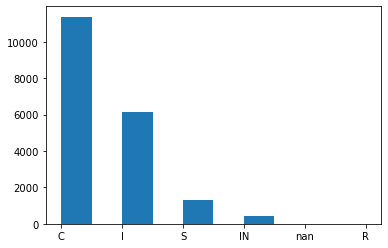

In [42]:
## EDA understand distribution of targets
plt.hist(list(full_df_reordered['passResult']))

(array([6.0000e+00, 2.9000e+01, 7.6000e+01, 3.2100e+02, 1.1690e+03,
        1.1037e+04, 5.5620e+03, 9.3100e+02, 9.3000e+01, 1.5000e+01]),
 array([-11.93595147,  -9.87942471,  -7.82289795,  -5.76637119,
         -3.70984443,  -1.65331767,   0.40320909,   2.45973585,
          4.51626262,   6.57278938,   8.62931614]),
 <BarContainer object of 10 artists>)

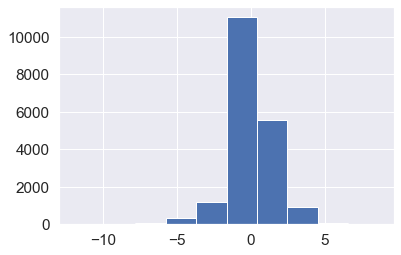

In [90]:
plt.hist(list(full_df_reordered['epa']))

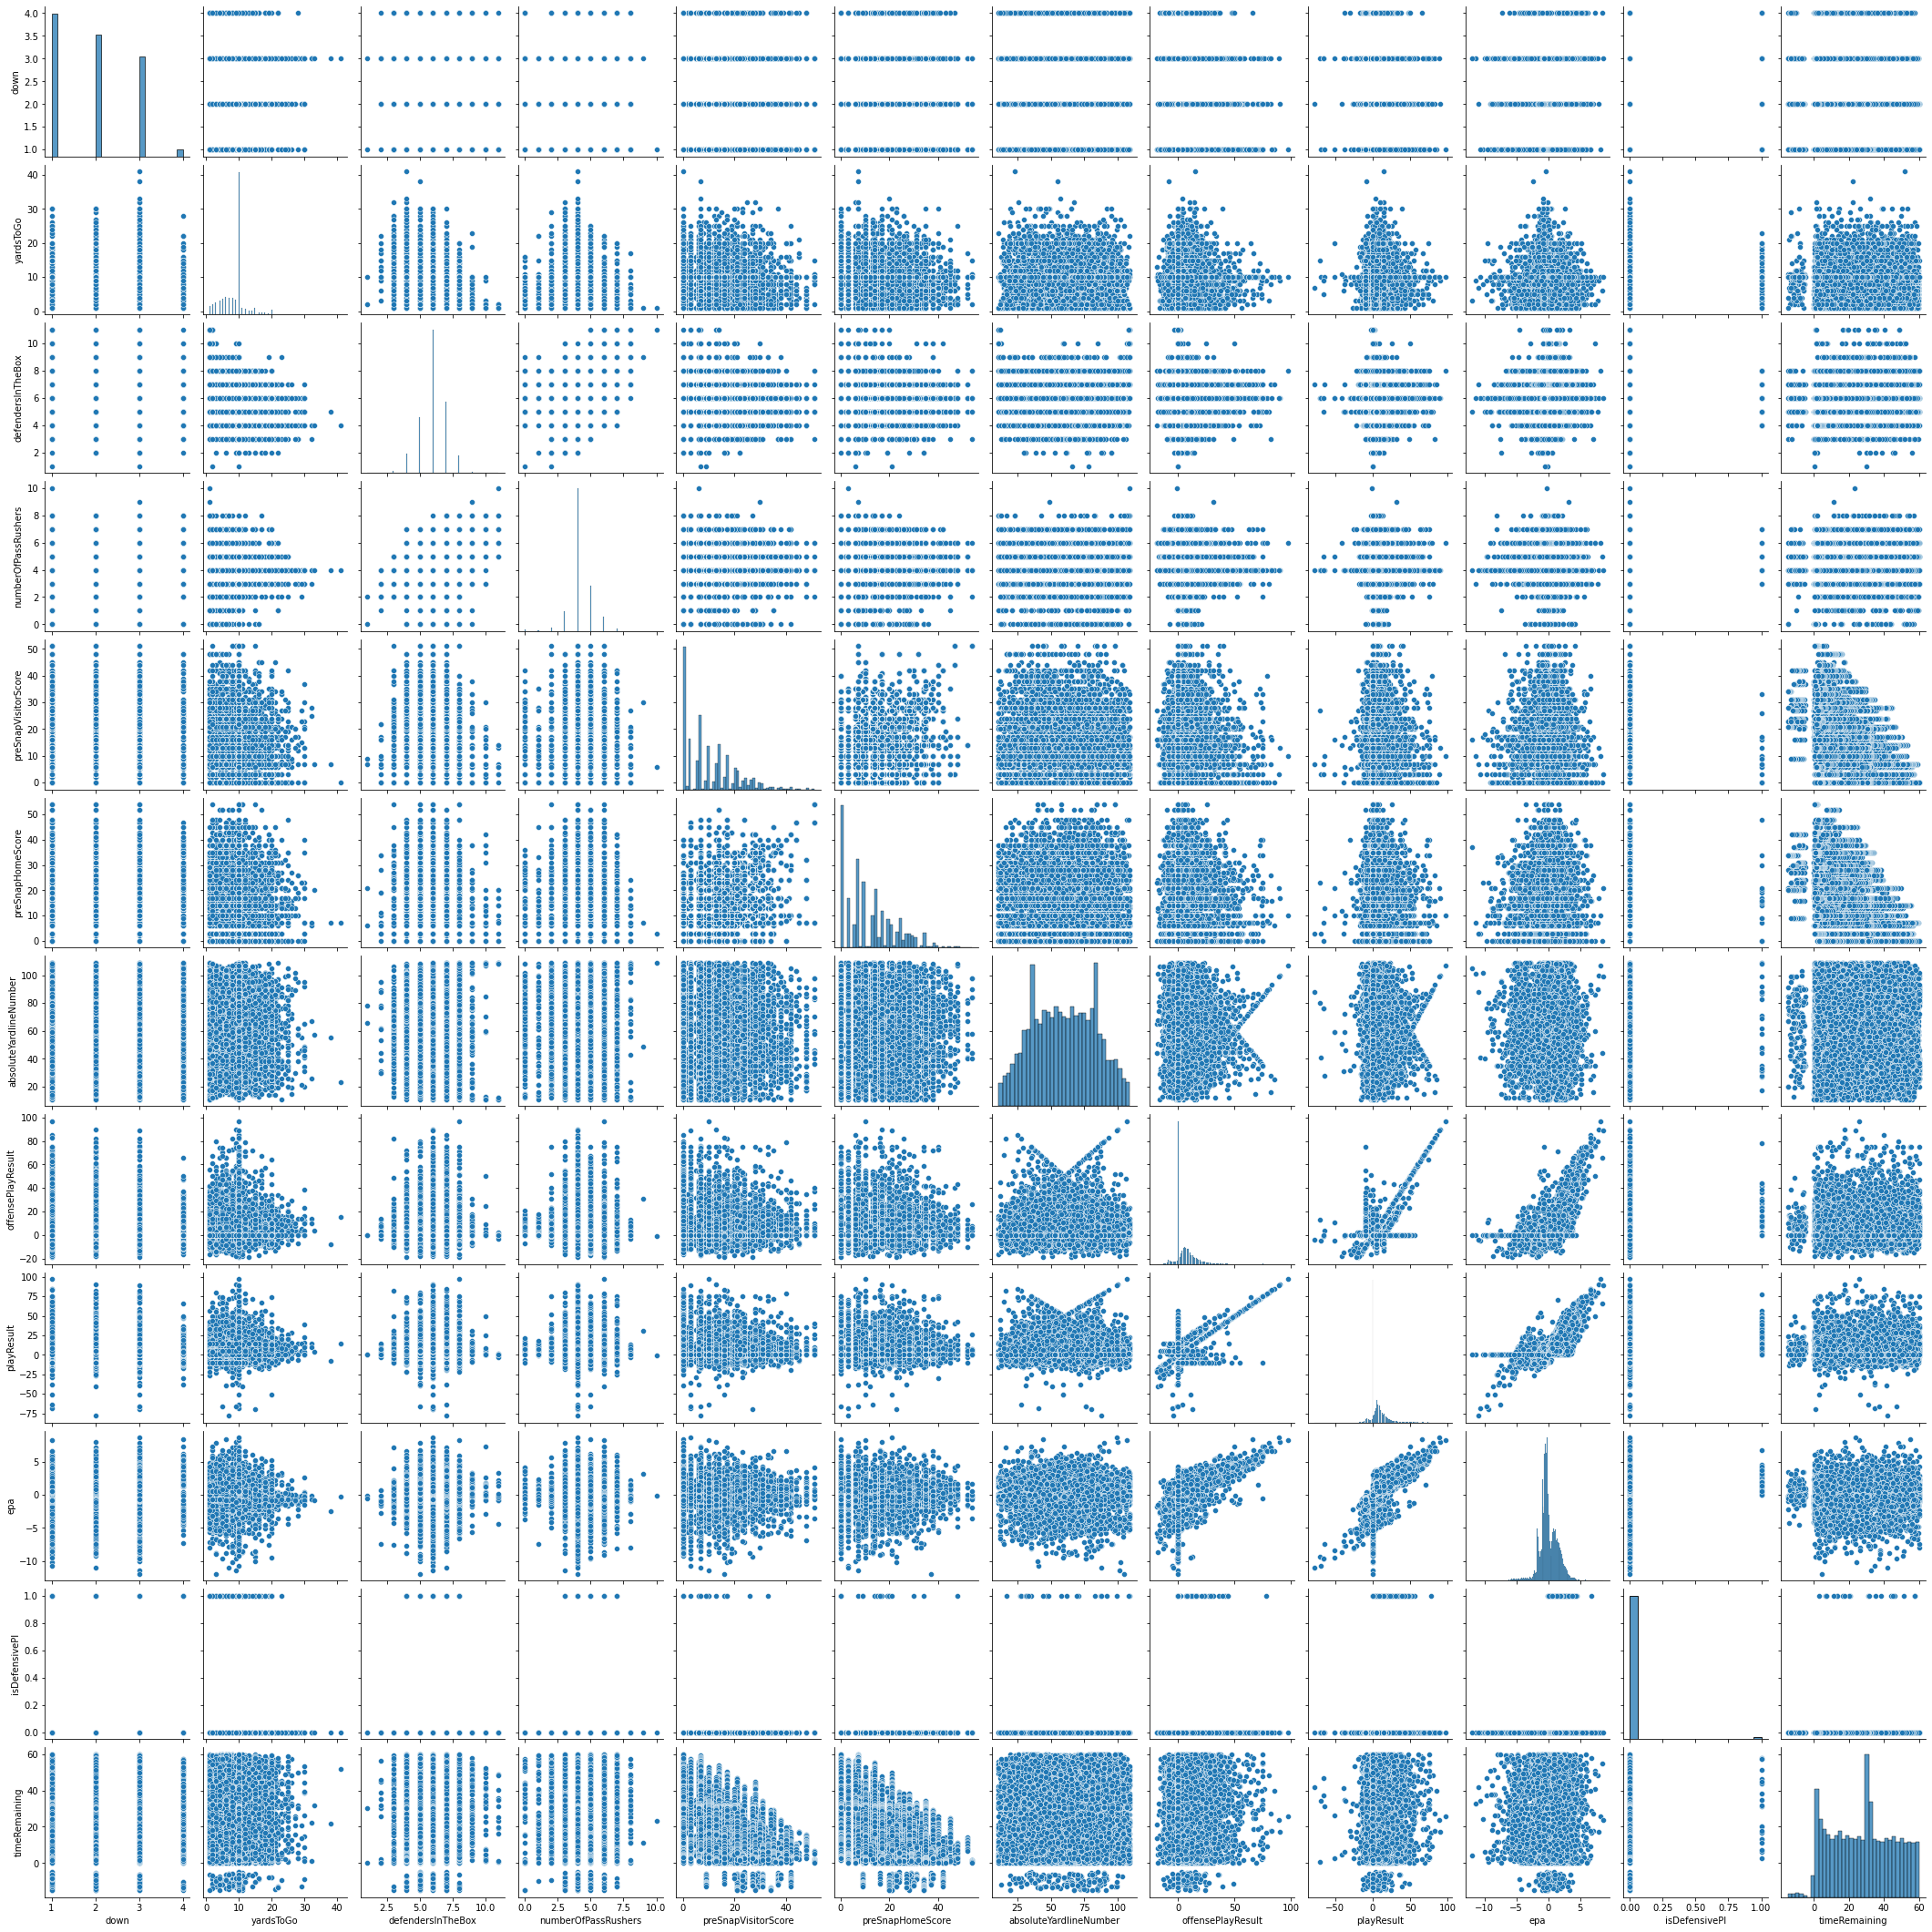

In [43]:
## EDA correlation of variables
sns.pairplot(full_df_reordered[['down',
 'yardsToGo',
 'defendersInTheBox',
 'numberOfPassRushers',
 'preSnapVisitorScore',
 'preSnapHomeScore',
 'absoluteYardlineNumber',
 'passResult',
 'offensePlayResult',
 'playResult',
 'epa',
 'isDefensivePI',
 'timeRemaining']])

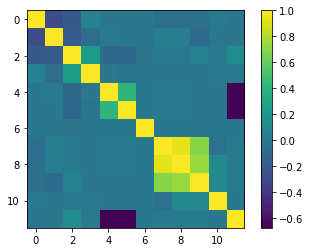

In [44]:
M = full_df_reordered[['down',
 'yardsToGo',
 'defendersInTheBox',
 'numberOfPassRushers',
 'preSnapVisitorScore',
 'preSnapHomeScore',
 'absoluteYardlineNumber',
 'passResult',
 'offensePlayResult',
 'playResult',
 'epa',
 'isDefensivePI',
 'timeRemaining']].corr()
M = M.dropna(thresh=2)
M = M.dropna(axis=1, thresh=2)
plt.imshow(M)
plt.colorbar()
plt.show()

In [45]:
M

down  yardsToGo  defendersInTheBox  \
down                    1.000000  -0.276123          -0.198178   
yardsToGo              -0.276123   1.000000          -0.181236   
defendersInTheBox      -0.198178  -0.181236           1.000000   
numberOfPassRushers     0.069329  -0.079169           0.237950   
preSnapVisitorScore    -0.013084   0.010068          -0.097810   
preSnapHomeScore       -0.007228   0.003595          -0.115826   
absoluteYardlineNumber  0.002834  -0.002560          -0.008001   
offensePlayResult      -0.063911   0.040389           0.007371   
playResult             -0.066480   0.039519           0.009647   
epa                    -0.056965  -0.092148           0.063781   
isDefensivePI           0.014154  -0.012971           0.009171   
timeRemaining          -0.015483  -0.009049           0.148415   

                        numberOfPassRushers  preSnapVisitorScore  \
down                               0.069329            -0.013084   
yardsToGo                         -0.079169             0.010068   
defendersInTheBox                  0.237950            -0.097810   
numberOfPassRushers                1.000000            -0.012711   
preSnapVisitorScore               -0.012711             1.000000   
preSnapHomeScore                  -0.021216             0.419709   
absoluteYardlineNumber             0.000634             0.004587   
offensePlayResult                 -0.001797             0.006263   
playResult                        -0.002532             0.005385   
epa                               -0.008584            -0.005007   
isDefensivePI                      0.014346            -0.006495   
timeRemaining                      0.012173            -0.675409   

                        preSnapHomeScore  absoluteYardlineNumber  \
down                           -0.007228                0.002834   
yardsToGo                       0.003595               -0.002560   
defendersInTheBox              -0.115826               -0.008001   
numberOfPassRushers            -0.021216                0.000634   
preSnapVisitorScore             0.419709                0.004587   
preSnapHomeScore                1.000000               -0.001514   
absoluteYardlineNumber         -0.001514                1.000000   
offensePlayResult               0.011337                0.002485   
playResult                      0.009910                0.001031   
epa                             0.004068                0.002367   
isDefensivePI                   0.003077                0.002519   
timeRemaining                  -0.669392               -0.004421   

                        offensePlayResult  playResult       epa  \
down                            -0.063911   -0.066480 -0.056965   
yardsToGo                        0.040389    0.039519 -0.092148   
defendersInTheBox                0.007371    0.009647  0.063781   
numberOfPassRushers             -0.001797   -0.002532 -0.008584   
preSnapVisitorScore              0.006263    0.005385 -0.005007   
preSnapHomeScore                 0.011337    0.009910  0.004068   
absoluteYardlineNumber           0.002485    0.001031  0.002367   
offensePlayResult                1.000000    0.931035  0.696615   
playResult                       0.931035    1.000000  0.744617   
epa                              0.696615    0.744617  1.000000   
isDefensivePI                   -0.045012    0.123340  0.115152   
timeRemaining                    0.013253    0.014616  0.019624   

                        isDefensivePI  timeRemaining  
down                         0.014154      -0.015483  
yardsToGo                   -0.012971      -0.009049  
defendersInTheBox            0.009171       0.148415  
numberOfPassRushers          0.014346       0.012173  
preSnapVisitorScore         -0.006495      -0.675409  
preSnapHomeScore             0.003077      -0.669392  
absoluteYardlineNumber       0.002519      -0.004421  
offensePlayResult           -0.045012       0.013253  
playResult                   0.1

In [46]:
## Save target columns to their own dataframe
targets = pd.DataFrame(full_df_reordered[['passResult','offensePlayResult','playResult','epa','isDefensivePI']])

In [47]:
## Drop target columns, one-hot encode categorical variables
full_df_reordered = full_df_reordered.drop(['passResult','offensePlayResult','playResult','epa','isDefensivePI'],axis=1)
full_df_reordered = full_df_reordered.drop(['gameId','playId','game_play_ID'], axis = 1)

full_df_reordered.to_csv('full_df_reordered.csv')

full_df_reordered = full_df_reordered.join(pd.get_dummies(full_df_reordered.offenseFormation, prefix='offenseFormation'))
full_df_reordered = full_df_reordered.join(pd.get_dummies(full_df_reordered.personnelO, prefix='personnelO'))
full_df_reordered = full_df_reordered.join(pd.get_dummies(full_df_reordered.personnelD, prefix='personnelD'))
full_df_reordered = full_df_reordered.drop(['offenseFormation', 'personnelO', 'personnelD'], axis = 1)

In [48]:
full_df_reordered = full_df_reordered.drop(to_dummy, axis = 1)

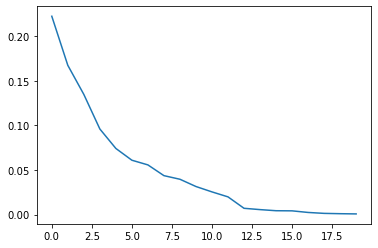

In [49]:
## PCA for dimension reduction
full_df_reordered = full_df_reordered.fillna(0)
pca = PCA()
pca.fit(full_df_reordered)
plt.plot(pca.explained_variance_ratio_[0:20])

In [50]:
## Test Models
pca = PCA(n_components = 13)
pca_data = pd.DataFrame(pca.fit_transform(full_df_reordered))
X_train,X_test,y_train,y_test = train_test_split(pca_data, targets['offensePlayResult'], test_size = 0.33, random_state = 42)
regr = RandomForestRegressor(max_features = 'auto', min_samples_leaf = 2, random_state = 357)
regr.fit(X_train,y_train)
regr.score(X_train,y_train), regr.score(X_test,y_test)

(0.7353452924808284, -0.09553118263801608)

In [51]:
X_train,X_test,y_train,y_test = train_test_split(full_df_reordered, targets['offensePlayResult'], test_size = 0.33, random_state = 42)
regr = RandomForestRegressor(max_features = 'auto', min_samples_leaf = 2, random_state = 357)
regr.fit(X_train,y_train)
regr.score(X_train,y_train), regr.score(X_test,y_test)

(0.752208294521326, -0.05770814195819973)

## Z Transformed Data

In [52]:
full_df_reordered_transformed = full_df_reordered.apply(stats.zscore)
full_df_reordered_transformed

down  yardsToGo  defendersInTheBox  numberOfPassRushers  \
0     -1.084262   1.528919           0.918898            -0.067085   
1     -1.084262   0.270776           0.918898            -0.067085   
2      0.093876   0.270776          -0.015641            -0.067085   
3      1.272015   0.270776          -0.015641             0.795075   
4      1.272015  -1.993880           1.853438             1.657235   
...         ...        ...                ...                  ...   
19234  0.093876  -0.987366           0.918898            -3.515726   
19235  1.272015  -0.484109          -0.015641            -3.515726   
19236  1.272015  -1.238995          -0.015641            -3.515726   
19237  1.272015  -1.993880           0.918898            -3.515726   
19238 -1.084262   0.270776          -0.015641            -3.515726   

       preSnapVisitorScore  preSnapHomeScore  absoluteYardlineNumber  \
0                -1.058652         -1.135487                1.253081   
1                -1.058652         -1.135487               -0.348228   
2                -1.058652         -1.135487               -0.348228   
3                -1.058652         -1.135487               -0.348228   
4                -1.058652         -1.135487               -1.832369   
...                    ...               ...                     ...   
19234            -1.058652         -1.135487               -2.261989   
19235            -1.058652         -1.135487               -2.261989   
19236            -1.058652         -1.135487               -2.261989   
19237            -1.058652         -1.135487               -2.261989   
19238            -1.058652         -1.135487               -2.261989   

       timeRemaining  QB1height  QB1weight  ...  personnelD_5 DL, 2 LB, 4 DB  \
0           1.833042   0.242012  -0.425798  ...                    -0.069695   
1           1.730990   0.242012  -0.425798  ...                    -0.069695   
2           1.726352   0.242012  -0.425798  ...                    -0.069695   
3           1.722641   0.242012  -0.425798  ...                    -0.069695   
4           1.609456   0.242012  -0.425798  ...                    -0.069695   
...              ...        ...        ...  ...                          ...   
19234      -1.506824  -0.021058  -0.294062  ...                    -0.069695   
19235      -1.506824   0.505082   0.759825  ...                    -0.069695   
19236      -1.506824   0.505082   0.298749  ...                    -0.069695   
19237      -1.506824   0.505082   0.298749  ...                    -0.069695   
19238      -1.506824  -0.284128  -0.755138  ...                    -0.069695   

       personnelD_5 DL, 3 LB, 2 DB, 1 OL  personnelD_5 DL, 3 LB, 3 DB  \
0                              -0.012488                    -0.026986   
1                              -0.012488                    -0.026986   
2                              -0.012488                    -0.026986   
3                              -0.012488                    -0.026986   
4                              -0.012488                    -0.026986   
...                                  ...                          ...   
19234                          -0.012488                    -0.026986   
19235                          -0.012488                    -0.026986   
19236                          -0.012488                    -0.026986   
19237                          -0.012488                    -0.026986   
19238                          -0.012488                    -0.026986   

       personnelD_5 DL, 4 LB, 2 DB  personnelD_5 DL, 5 LB, 1 DB  \
0                         -0.00721                     -0.00721   
1                         -0.00721                     -0.00721   
2                         -0.00721                     -0.00721   
3                         -0.00721                     -0.00721   
4                         -0.00721                     -0.00721   
...                            ...                          ...  

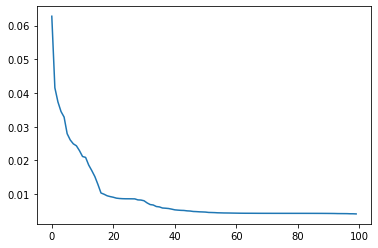

In [53]:
## Redo PCA for dimension reduction
full_df_reordered_transformed = full_df_reordered_transformed.fillna(0)
pca = PCA()
pca.fit(full_df_reordered_transformed)
plt.plot(pca.explained_variance_ratio_[0:100])

In [54]:
## Iteratively generate models with changed hyperparameters
pca = PCA(n_components = 35)
pca_data = pd.DataFrame(pca.fit_transform(full_df_reordered_transformed))
X_train,X_test,y_train,y_test = train_test_split(pca_data, targets['epa'], test_size = 0.33, random_state = 357)

mse_list = []
leaf_list = []
depth_list = []
for leaf in range(1,11):
    for depth in range(1,36):
        leaf_list.append(leaf)
        depth_list.append(depth)
        
        regr = RandomForestRegressor(max_features = 'sqrt', min_samples_leaf = leaf, max_depth = depth, random_state = 357, n_jobs=-1)
        regr.fit(X_train,y_train)
        mse_list.append(mean_squared_error(y_test,regr.predict(X_test)))

In [55]:
## Collect results into single dataframe and graph results
results = pd.DataFrame()
results['min_samples_leaf'] = leaf_list
results['max_depth'] = depth_list
results['MSE'] = mse_list

NameError: name 'leaf_list' is not defined

In [57]:
results.groupby(['min_samples_leaf','max_depth']).mean().sort_values(by = 'MSE')[0:10]

MSE
min_samples_leaf max_depth          
2                8          2.460493
8                6          2.462045
9                6          2.462501
4                8          2.462859
2                6          2.462881
                 10         2.462896
3                8          2.462920
                 4          2.463100
9                4          2.463116
1                5          2.463130

In [58]:
import plotly.express as px
fig = px.scatter_3d(results, x='min_samples_leaf', y='max_depth', z='MSE',
                    color='MSE',
                    title="Random Forest Regression CV")
fig.show()

In [59]:
## Baseline Always predicting the mean EPA
np.mean(np.square(targets['epa'] - np.mean(targets['epa'])))

2.4986347012959333

In [57]:
## Encoding next target
targets['passResult'] = targets['passResult'].fillna('NA')
cleanup_nums = {"passResult":{"C": 1, "I": 2, "S": 3, "IN": 4, "NA": 5, "R": 6}}
targets = targets.replace(cleanup_nums)

In [63]:
## Re-preform modeling with classification
pca = PCA(n_components = 35)
pca_data = pd.DataFrame(pca.fit_transform(full_df_reordered_transformed))

X_train,X_test,y_train,y_test = train_test_split(pca_data, targets['passResult'], test_size = 0.33, random_state = 357)

acc_list = []
leaf_list = []
depth_list = []
for leaf in range(1,11):
    for depth in range(1,36):
        leaf_list.append(leaf)
        depth_list.append(depth)
        
        cls = RandomForestClassifier(max_features = 'sqrt', min_samples_leaf = leaf, max_depth = depth, random_state = 357, n_jobs=-1)
        cls.fit(X_train,y_train)
        acc_list.append(cls.score(X_test,y_test))

In [64]:
## Collect results into single dataframe and graph results
results_cat = pd.DataFrame()
results_cat['min_samples_leaf'] = leaf_list
results_cat['max_depth'] = depth_list
results_cat['Accuracy'] = acc_list

In [65]:
results_cat.groupby(['min_samples_leaf','max_depth']).mean().sort_values(by = 'Accuracy', ascending = False)[0:10]

Accuracy
min_samples_leaf max_depth          
4                13         0.601827
8                14         0.601670
9                13         0.601512
                 12         0.601197
4                11         0.601197
10               11         0.601040
5                11         0.601040
8                13         0.601040
2                11         0.600882
3                11         0.600882

In [66]:
import plotly.express as px
fig = px.scatter_3d(results_cat, x='min_samples_leaf', y='max_depth', z='Accuracy',
                    color='Accuracy',
                    title="Random Forest Classification CV")
fig.show()

In [ ]:
## Baseline, Always predicting a catch
len(targets[targets['passResult'] == 1])/len(targets)

In [58]:
## Add play result data back into model for post-play epa prediction
full_df_reordered_transformed['offensePlayResult'] = targets['offensePlayResult']
full_df_reordered_transformed['isDefensivePI'] = targets['isDefensivePI']

0.7301619001138944

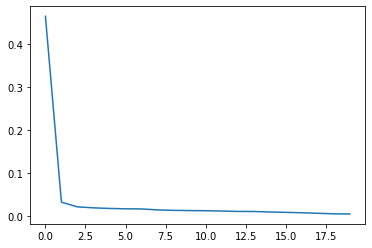

In [60]:
## Re-Model EPA
full_df_reordered_transformed['passResult'] = targets['passResult']
full_df_reordered_transformed['playResult'] = targets['playResult']
pca = PCA()
pca.fit(full_df_reordered_transformed)
plt.plot(pca.explained_variance_ratio_[0:20])
pca = PCA(n_components = 7)
pca_data = pd.DataFrame(pca.fit_transform(full_df_reordered_transformed))

X_train,X_test,y_train,y_test = train_test_split(pca_data, targets['epa'], test_size = 0.33, random_state = 357)
regr = RandomForestRegressor(max_features = 'auto', min_samples_leaf = 8, max_depth = 7, random_state = 357)
regr.fit(X_train,y_train)
mean_squared_error(y_test,regr.predict(X_test))

In [61]:
full_df_reordered_transformed = full_df_reordered_transformed.apply(stats.zscore)

In [63]:
full_df_reordered_transformed.apply(stats.zscore)

down  yardsToGo  defendersInTheBox  numberOfPassRushers  \
0     -1.084262   1.528919           0.918898            -0.067085   
1     -1.084262   0.270776           0.918898            -0.067085   
2      0.093876   0.270776          -0.015641            -0.067085   
3      1.272015   0.270776          -0.015641             0.795075   
4      1.272015  -1.993880           1.853438             1.657235   
...         ...        ...                ...                  ...   
19234  0.093876  -0.987366           0.918898            -3.515726   
19235  1.272015  -0.484109          -0.015641            -3.515726   
19236  1.272015  -1.238995          -0.015641            -3.515726   
19237  1.272015  -1.993880           0.918898            -3.515726   
19238 -1.084262   0.270776          -0.015641            -3.515726   

       preSnapVisitorScore  preSnapHomeScore  absoluteYardlineNumber  \
0                -1.058652         -1.135487                1.253081   
1                -1.058652         -1.135487               -0.348228   
2                -1.058652         -1.135487               -0.348228   
3                -1.058652         -1.135487               -0.348228   
4                -1.058652         -1.135487               -1.832369   
...                    ...               ...                     ...   
19234            -1.058652         -1.135487               -2.261989   
19235            -1.058652         -1.135487               -2.261989   
19236            -1.058652         -1.135487               -2.261989   
19237            -1.058652         -1.135487               -2.261989   
19238            -1.058652         -1.135487               -2.261989   

       timeRemaining  QB1height  QB1weight  ...  personnelD_5 DL, 5 LB, 1 DB  \
0           1.833042   0.242012  -0.425798  ...                     -0.00721   
1           1.730990   0.242012  -0.425798  ...                     -0.00721   
2           1.726352   0.242012  -0.425798  ...                     -0.00721   
3           1.722641   0.242012  -0.425798  ...                     -0.00721   
4           1.609456   0.242012  -0.425798  ...                     -0.00721   
...              ...        ...        ...  ...                          ...   
19234      -1.506824  -0.021058  -0.294062  ...                     -0.00721   
19235      -1.506824   0.505082   0.759825  ...                     -0.00721   
19236      -1.506824   0.505082   0.298749  ...                     -0.00721   
19237      -1.506824   0.505082   0.298749  ...                     -0.00721   
19238      -1.506824  -0.284128  -0.755138  ...                     -0.00721   

       personnelD_6 DL, 1 LB, 4 DB  personnelD_6 DL, 2 LB, 3 DB  \
0                        -0.010196                    -0.012488   
1                        -0.010196                    -0.012488   
2                        -0.010196                    -0.012488   
3                        -0.010196                    -0.012488   
4                        -0.010196                    -0.012488   
...                            ...                          ...   
19234                    -0.010196                    -0.012488   
19235                    -0.010196                    -0.012488   
19236                    -0.010196                    -0.012488   
19237                    -0.010196                    -0.012488   
19238                    -0.010196                    -0.012488   

       personnelD_6 DL, 3 LB, 2 DB  personnelD_6 DL, 4 LB, 1 DB  \
0                        -0.024982                    -0.024982   
1                        -0.024982                    -0.024982   
2                        -0.024982                    -0.024982   
3                        -0.024982                    -0.024982   
4                        40.028115                    -0.024982   
...                            ...                          ...   
19234                    -0.024982                    -0.024982   
192

In [82]:
full_df_reordered

down  yardsToGo  defendersInTheBox  numberOfPassRushers  \
0         1         15                7.0                  4.0   
1         1         10                7.0                  4.0   
2         2         10                6.0                  4.0   
3         3         10                6.0                  5.0   
4         3          1                8.0                  6.0   
...     ...        ...                ...                  ...   
19234     2          5                7.0                  0.0   
19235     3          7                6.0                  0.0   
19236     3          4                6.0                  0.0   
19237     3          1                7.0                  0.0   
19238     1         10                6.0                  0.0   

       preSnapVisitorScore  preSnapHomeScore  absoluteYardlineNumber  \
0                      0.0               0.0                    90.0   
1                      0.0               0.0                    49.0   
2                      0.0               0.0                    49.0   
3                      0.0               0.0                    49.0   
4                      0.0               0.0                    11.0   
...                    ...               ...                     ...   
19234                  0.0               0.0                     0.0   
19235                  0.0               0.0                     0.0   
19236                  0.0               0.0                     0.0   
19237                  0.0               0.0                     0.0   
19238                  0.0               0.0                     0.0   

       timeRemaining  QB1height  QB1weight  ...  \
0          60.000000   6.333333      217.0  ...   
1          58.166667   6.333333      217.0  ...   
2          58.083333   6.333333      217.0  ...   
3          58.016667   6.333333      217.0  ...   
4          55.983333   6.333333      217.0  ...   
...              ...        ...        ...  ...   
19234       0.000000   6.250000      219.0  ...   
19235       0.000000   6.416667      235.0  ...   
19236       0.000000   6.416667      228.0  ...   
19237       0.000000   6.416667      228.0  ...   
19238       0.000000   6.166667      212.0  ...   

       personnelD_5 DL, 3 LB, 2 DB, 1 OL  personnelD_5 DL, 3 LB, 3 DB  \
0                                      0                            0   
1                                      0                            0   
2                                      0                            0   
3                                      0                            0   
4                                      0                            0   
...                                  ...                          ...   
19234                                  0                            0   
19235                                  0                            0   
19236                                  0                            0   
19237                                  0                            0   
19238                                  0                            0   

       personnelD_5 DL, 4 LB, 2 DB  personnelD_5 DL, 5 LB, 1 DB  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
19234                            0                            0   
19235                            0                            0   
19236                            0                            0   
19237                            0                            0   
19238                            0                            0   

       personnelD_6 DL, 1 LB, 4 DB  personnelD_6 DL, 2

In [64]:
full_df_reordered['epa'] = targets['epa']

In [65]:
## Calculate Big play label
targets['big_play_label'] = np.where((full_df_reordered['epa'] >= 2) & (full_df_reordered['absoluteYardlineNumber'] > 40),-1,1)

In [67]:
## Drop target columns again
full_df_reordered_transformed_dropped = full_df_reordered_transformed.drop(['passResult','offensePlayResult','playResult','isDefensivePI'], axis = 1)

In [68]:
## Isolation forest for outlier (big play) detection
from sklearn.ensemble import IsolationForest

pca = PCA(n_components = 35)
pca_data = pd.DataFrame(pca.fit_transform(full_df_reordered_transformed_dropped))

X_train,X_test,y_train,y_test = train_test_split(pca_data, targets['big_play_label'], test_size = 0.33, random_state = 357)

isof = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, max_features=1.0, bootstrap=False, n_jobs=-1, random_state=357, verbose=2)
isof.fit(X_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Building estimator 1 of 17 for this parallel run (total 100)...Building estimator 1 of 17 for this parallel run (total 100)...Building estimator 1 of 17 for this parallel run (total 100)...

Building estimator 1 of 17 for this parallel run (total 100)...

Building estimator 1 of 16 for this parallel run (total 100)...
Building estimator 1 of 16 for this parallel run (total 100)...
Building estimator 2 of 17 for this parallel run (total 100)...
Building estimator 2 of 17 for this parallel run (total 100)...
Building estimator 2 of 17 for this parallel run (total 100)...
Building estimator 2 of 17 for this parallel run (total 100)...Building estimator 2 of 16 for this parallel run (total 100)...Building estimator 2 of 16 for this parallel run (total 100)...


Building estimator 3 of 17 for this parallel run (total 100)...
Building estimator 3 of 17 for this parallel run (total 100)...
Building estimator 3 of 17 for this parallel run (total 100)...
Building estimator 3 of 16 for this para

[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.5s finished


IsolationForest(contamination=0.01, n_jobs=-1, random_state=357, verbose=2)

In [69]:
## Generate Results
from sklearn.metrics import average_precision_score, confusion_matrix, f1_score, precision_recall_curve, accuracy_score, precision_score, recall_score
y_pred_train = isof.predict(X_train)
y_pred_test = isof.predict(X_test)

In [70]:
print("Accuracy: {:.3f}".format(accuracy_score(y_train, y_pred_train)))
print("Precision: {:.3f}".format(precision_score(y_train, y_pred_train)))  
print("Recall: {:.3f}".format(recall_score(y_train, y_pred_train)))  
print("f1 Score: {:.3f}".format(f1_score(y_train, y_pred_train)))  
print("Area Under the Precision-Recall Curve (AUPRC): {:.3f}".format(average_precision_score(y_train, y_pred_train)))

Accuracy: 0.926
Precision: 0.935
Recall: 0.990
f1 Score: 0.962
Area Under the Precision-Recall Curve (AUPRC): 0.935


In [71]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred_test)))  
print("Precision: {:.3f}".format(precision_score(y_test, y_pred_test)))  
print("Recall: {:.3f}".format(recall_score(y_test, y_pred_test)))  
print("f1 Score: {:.3f}".format(f1_score(y_test, y_pred_test)))  
print("Area Under the Precision-Recall Curve (AUPRC): {:.3f}".format(average_precision_score(y_test, y_pred_test)))

Accuracy: 0.924
Precision: 0.932
Recall: 0.990
f1 Score: 0.960
Area Under the Precision-Recall Curve (AUPRC): 0.932


In [72]:
confmat_train = confusion_matrix(y_train, y_pred_train)
confmat_test = confusion_matrix(y_test, y_pred_test)

<AxesSubplot:>

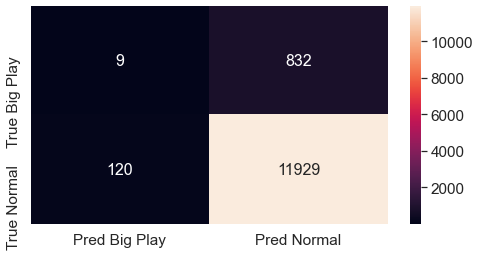

In [73]:
import seaborn as sns
confmat_train = pd.DataFrame(confmat_train,
                  ['True Big Play','True Normal'],['Pred Big Play','Pred Normal'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)# for label size
sns.heatmap(confmat_train, annot=True, annot_kws={"size": 16},fmt='g')

<AxesSubplot:>

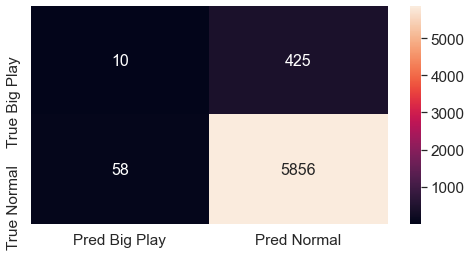

In [74]:
import seaborn as sns
confmat_test = pd.DataFrame(confmat_test,
                  ['True Big Play','True Normal'],['Pred Big Play','Pred Normal'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)# for label size
sns.heatmap(confmat_test, annot=True, annot_kws={"size": 16},fmt='g')

In [78]:
np.where(isof.predict(pca_data) == -1)[0]

197

In [88]:
## Get some examples
plays_reread = pd.read_csv('nfl-big-data-bowl-2021/plays.csv')
plays_reread.iloc[np.where(isof.predict(pca_data) == -1)[0]]

gameId  playId                                    playDescription  \
4      2018090600     256  (10:59) (Shotgun) M.Ryan pass incomplete short...   
505    2018090907    1465  (2:47) B.Bortles pass short right to T.Yeldon ...   
809    2018090912    2439  (3:46) (No Huddle, Shotgun) A.Rodgers pass inc...   
1197   2018091603     637  (3:46) J.Bushrod reported in as eligible.  D.B...   
1225   2018091603    2407  (8:14) A.Corbett reported in as eligible.  T.T...   
...           ...     ...                                                ...   
18724  2018092306    1982  (14:51) (Shotgun) R.Tannehill pass short left ...   
18815  2018101404    2920  (12:26) B.Sowell reported in as eligible.  M.T...   
18818  2018101407     325  (8:18) R.Wilson pass incomplete short right to...   
19094  2018120904    4195  (2:50) (Shotgun) D.Watson pass incomplete shor...   
19166  2018121610    1089  (12:12) (Shotgun) B.Roethlisberger pass incomp...   

       quarter  down  yardsToGo possessionTeam           playType  \
4            1     3          1            ATL     play_type_pass   
505          2     1          1            JAX     play_type_pass   
809          3     3          9             GB     play_type_pass   
1197         1     1          2             NO     play_type_pass   
1225         3     1          1            CLE     play_type_sack   
...        ...   ...        ...            ...                ...   
18724        3     1         10            MIA  play_type_unknown   
18815        4     1          3            CHI  play_type_unknown   
18818        1     2          1            SEA  play_type_unknown   
19094        4     2         10            HOU  play_type_unknown   
19166        2     2          4            PIT  play_type_unknown   

      yardlineSide  yardlineNumber  ... preSnapHomeScore gameClock  \
4              PHI               1  ...              0.0  10:59:00   
505            NYG               1  ...              3.0  02:47:00   
809            CHI              23  ...              0.0  03:46:00   
1197           CLE               2  ...              0.0  03:46:00   
1225            NO               1  ...              3.0  08:14:00   
...            ...             ...  ...              ...       ...   
18724          MIA              23  ...              NaN       NaN   
18815          MIA               3  ...              NaN       NaN   
18818          OAK               1  ...              NaN       NaN   
19094          IND              12  ...              NaN       NaN   
19166           NE              43  ...              NaN       NaN   

       absoluteYardlineNumber  penaltyCodes penaltyJerseyNumbers passResult  \
4                        11.0           NaN                  NaN          I   
505                     109.0           NaN                  NaN          C   
809                      33.0           NaN                  NaN          I   
1197                    108.0           NaN                  NaN          I   
1225                    109.0           NaN                  NaN          S   
...                       ...           ...                  ...        ...   
18724                     NaN           OPI               MIA 19          C   
18815                     NaN           OPI               CHI 80          C   
18818                     NaN            DH               OAK 59          I   
19094                     NaN            DH               IND 31          I   
19166                     NaN           DPI                NE 31          I   

       offensePlayResult  playResult       epa  isDefensivePI  
4                      0           0 -0.842272          False  
505                    1           1  1.353084          False  
809                    0           0 -1.036528          False  
1197                   0           0 -0.139081          False  
1225                  -1          -1 -0.200337          False  
...                  ...         ...       ... 

In [86]:
plays_reread['playDescription'][1647]

'(10:00) (Punt formation) K.Byard pass deep right to D.Cruikshank for 66 yards, TOUCHDOWN.'

In [87]:
plays_reread['playDescription'][16303]

'(4:12) C.Clark reported in as eligible.  C.McCaffrey pass short right to C.Manhertz for 50 yards, TOUCHDOWN.'